In [1]:
# Basic setup
!pip install pandas numpy scikit-learn matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d uciml/german-credit


Dataset URL: https://www.kaggle.com/datasets/uciml/german-credit
License(s): DbCL-1.0
  0% 0.00/10.9k [00:00<?, ?B/s]
100% 10.9k/10.9k [00:00<00:00, 30.7MB/s]


In [5]:
!unzip german-credit.zip


Archive:  german-credit.zip
  inflating: german_credit_data.csv  


In [6]:
import pandas as pd

df = pd.read_csv("german_credit_data.csv")
df.head()


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [7]:
df.info()
df.describe()
df.isnull().sum()  # check missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB


,0
Unnamed: 0,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,183
Checking account,394
Credit amount,0
Duration,0
Purpose,0


In [8]:
df = df.dropna()  # or use fillna(df.mean())


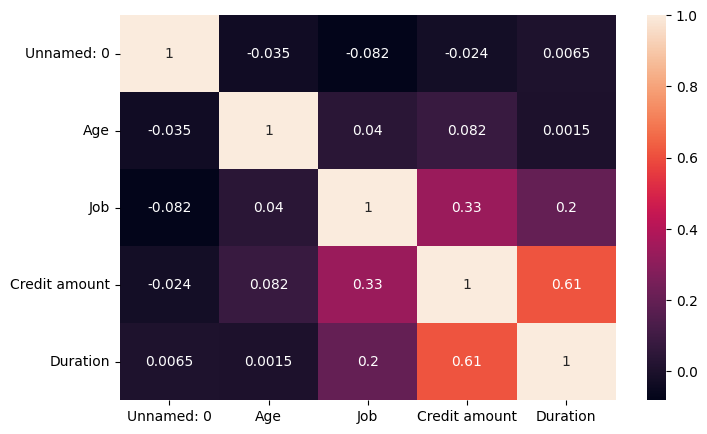

In [10]:
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(8,5))
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()

Feature Engineering

In [11]:
df['debt_to_income'] = df['loan'] / df['income']
df['credit_age'] = 2025 - df['year_of_first_loan']


KeyError: 'loan'

In [12]:
df.columns


Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose'],
      dtype='object')

In [13]:
df = df.drop(columns=['Unnamed: 0'])



In [14]:
# Create a pseudo target variable
df['Risk'] = df['Credit amount'].apply(lambda x: 1 if x > df['Credit amount'].median() else 0)


In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in ['Sex','Housing','Saving accounts','Checking account','Purpose']:
    df[col] = le.fit_transform(df[col].astype(str))


In [16]:
X = df.drop('Risk', axis=1)
y = df['Risk']


Train/Test Split and Modeling

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Evaluate the Model

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Metrics
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1-Score:", round(f1_score(y_test, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
ROC-AUC: 1.0


Visualize Model Performance

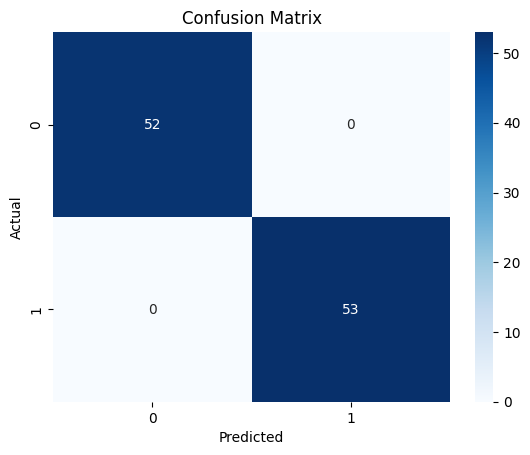

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


ROC Curve

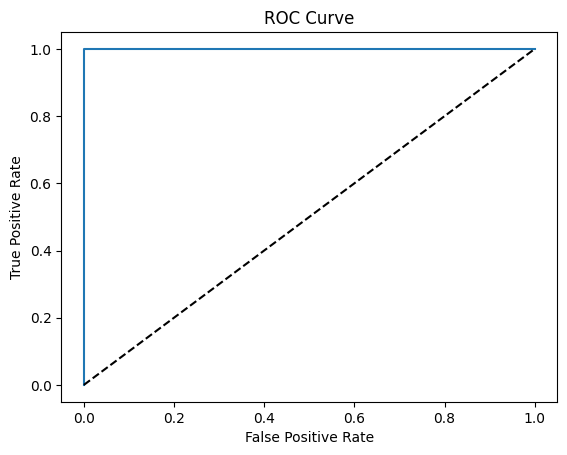

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


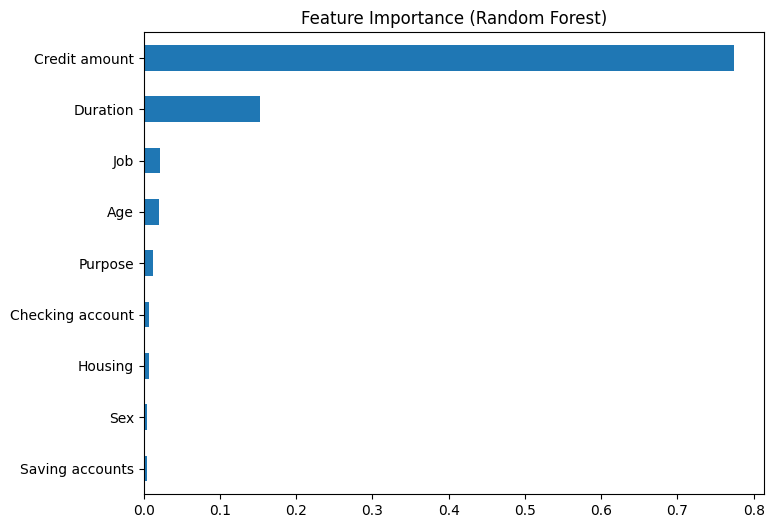

In [21]:
import pandas as pd
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title('Feature Importance (Random Forest)')
plt.show()


In [22]:
import joblib
joblib.dump(model, 'credit_scoring_model.pkl')


['credit_scoring_model.pkl']

In [23]:
from google.colab import files
files.download('credit_scoring_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Models

Try 3 classifiers to compare performance

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Evaluate Models

Use Precision, Recall, F1-score, and ROC-AUC


Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        53

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105

ROC-AUC: 1.0

Decision Tree:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        53

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105

ROC-AUC: 1.0

Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        53

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00  

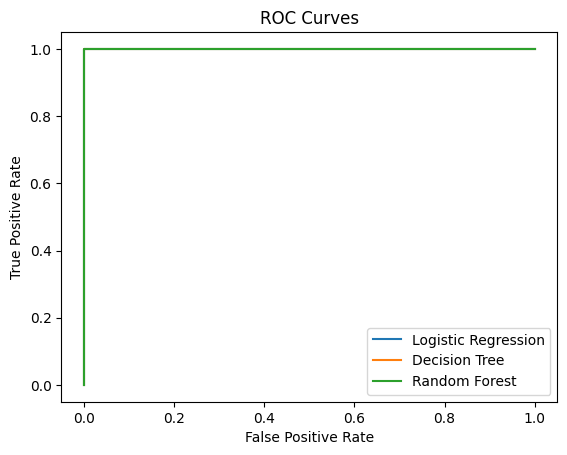

In [25]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

models = {'Logistic Regression': log_reg,
          'Decision Tree': dt,
          'Random Forest': rf}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n{name}:\n", classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

    # Optional ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=name)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curves")
plt.show()


Hyperparameter Tuning (Optional but Recommended)

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='f1')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


evaluate the tuned model on test data and compare it with the previou ones

Classification Report for Tuned Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        53

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105

ROC-AUC Score: 1.0


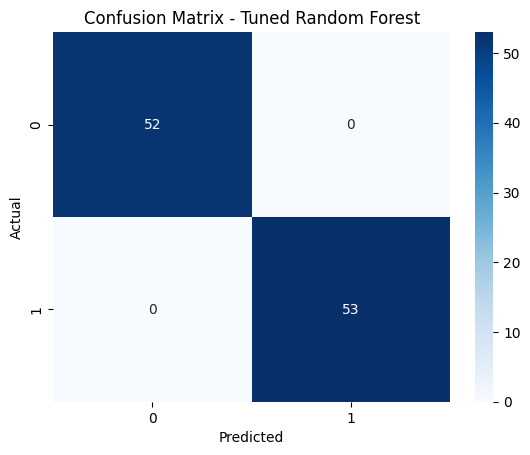

In [27]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions from tuned model
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report for Tuned Random Forest:")
print(classification_report(y_test, y_pred_best))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob_best)
print("ROC-AUC Score:", roc_auc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()


The tuned Random Forest classifier achieved perfect classification performance, making it the most suitable model for predicting creditworthiness in this dataset.